In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
from core.config import *

from core.datasets import VOC2012SegDataset
from core.data import crop_augment_preprocess_batch
from core.data_utils import flatten_list_of_lists
from core.color_map import apply_colormap
from core.torch_utils import get_activation
from models.seg import (SEGMODELS_REGISTRY,
    compute_seg_grad_cam, 
    compute_seg_grad_cam_pp,
    compute_seg_xgrad_cam,
    compute_seg_xres_cam,
    compute_seg_hires_grad_cam)
from core.viz import normalize_sim_maps, viz_seg_saliency_maps

import torch.nn.functional as F
import torchvision.transforms.v2 as T
from torchvision.transforms._presets import SemanticSegmentation
from torchvision.transforms.functional import to_pil_image
from torch.utils.data import DataLoader
from torch import nn
from torch.utils.hooks import RemovableHandle

from collections import OrderedDict
from functools import partial

In [3]:
config = setup_config(BASE_CONFIG, Path('/home/olivieri/exp/src/viz/seg/viz_config.yml'))
seg_config = config['seg']

In [ ]:
segmodel = SEGMODELS_REGISTRY.get(
    name=seg_config['model_name'],
    pretrained_weights_path=seg_config['pretrained_weights_path'],
    device=config['device'],
    adaptation=seg_config['adaptation']
)
segmodel.adapt()

In [5]:
if seg_config['checkpoint_path']:
    state_dict: OrderedDict = torch.load(seg_config['checkpoint_path'], map_location='cpu')
    model_state_dict = state_dict.get('model_state_dict', state_dict)
    segmodel.model.load_state_dict(model_state_dict)

In [6]:
img_idxs = np.random.choice(range(0, 80), size=10, replace=False).tolist() # reproducible
assert 16 not in img_idxs # one-shot example
img_idxs, len(img_idxs)

([30, 0, 22, 31, 18, 28, 10, 70, 4, 12], 10)

`img_idxs` should be array([30,  0, 22, 31, 18, 28, 10, 70,  4, 12]).

In [7]:
viz_ds = VOC2012SegDataset(
    root_path=config['datasets']['VOC2012_root_path'],
    split='prompts_split',
    device=config['device'],
    resize_size=config['seg']['image_size'],
    center_crop=True,
    img_idxs=img_idxs,
    with_unlabelled=False
)

In [8]:
viz_collate_fn = partial(
    crop_augment_preprocess_batch,
    crop_fn=T.CenterCrop(seg_config['image_size']),
    augment_fn=None,
    preprocess_fn=None
)

In [9]:
viz_dl = DataLoader(
    viz_ds,
    batch_size=seg_config['batch_size'],
    shuffle=False,
    generator=get_torch_gen(),
    collate_fn=viz_collate_fn,
)

In [10]:
handles: list[RemovableHandle] = list()
activations: dict[str, torch.Tensor] = dict()

In [11]:
target_layer: nn.Module = segmodel.model.backbone['16'] # (B, 960, 33, 33) bottleneck output
handle = target_layer.register_forward_hook(get_activation('target_layer_act', activations))
segmodel.add_handle(handle)

In [12]:
class_idx_to_name = {idx: name for idx, name in enumerate(viz_ds.get_classes())}
class_idx_to_name

{0: 'BACKGROUND',
 1: 'AEROPLANE',
 2: 'BICYCLE',
 3: 'BIRD',
 4: 'BOAT',
 5: 'BOTTLE',
 6: 'BUS',
 7: 'CAR',
 8: 'CAT',
 9: 'CHAIR',
 10: 'COW',
 11: 'DININGTABLE',
 12: 'DOG',
 13: 'HORSE',
 14: 'MOTORBIKE',
 15: 'PERSON',
 16: 'POTTEDPLANT',
 17: 'SHEEP',
 18: 'SOFA',
 19: 'TRAIN',
 20: 'TVMONITOR'}

In [13]:
target_classes = list(
    [
        [8, 1, 14, 15, 13],
        [15, 15, 10, 4, 20]
    ]
) # should be (num_batches, batch size)

flat_target_classes, target_classes_struct_info = flatten_list_of_lists(target_classes)
flat_target_class_names = [class_idx_to_name[class_idx] for class_idx in flat_target_classes]

In [19]:
cams_: list[torch.tensor] = []
bck_imgs_: list[torch.tensor] = []
gt_masks_: list[torch.tensor] = []
pr_masks_: list[torch.tensor] = []

for step, (scs_img, gts) in enumerate(viz_dl):
    scs = segmodel.preprocess_images(scs_img)
    scs.requires_grad_(True)

    scs: torch.Tensor = scs.to(config['device'])
    gts: torch.Tensor = gts.to(config['device']) # (B, H, W)

    logits = segmodel.model(scs)
    logits: torch.Tensor = logits["out"] if isinstance(logits, OrderedDict) else logits # (B, C, H, W)

    [print(f"{step*viz_dl.batch_size + i}: {gt.unique()}") for i, gt in enumerate(gts)]

    feature_volume: torch.Tensor = activations['target_layer_act'] # (B, 960, 33, 33)

    cams_b = compute_seg_grad_cam(
        feature_volume,
        logits,
        target_classes[step]
    )

    cams_.extend(torch.unbind(cams_b))
    bck_imgs_.extend(torch.unbind(scs_img))
    gt_masks_.extend(torch.unbind(gts))
    pr_masks_.extend(torch.unbind(logits.argmax(dim=1)))

cams = torch.stack(cams_)
bck_imgs = torch.stack(bck_imgs_)
gt_masks = torch.stack(gt_masks_)
pr_masks = torch.stack(pr_masks_)
cams.shape, bck_imgs.shape, gt_masks.shape, pr_masks.shape

0: tensor([0, 8], device='cuda:0')
1: tensor([ 0,  1, 15], device='cuda:0')
2: tensor([ 0, 14, 15], device='cuda:0')
3: tensor([ 0, 15], device='cuda:0')
4: tensor([ 0, 13], device='cuda:0')
5: tensor([ 0, 15], device='cuda:0')
6: tensor([ 0,  5, 15], device='cuda:0')
7: tensor([ 0, 10], device='cuda:0')
8: tensor([0, 4], device='cuda:0')
9: tensor([ 0, 20], device='cuda:0')


(torch.Size([10, 33, 33]),
 torch.Size([10, 3, 520, 520]),
 torch.Size([10, 520, 520]),
 torch.Size([10, 520, 520]))

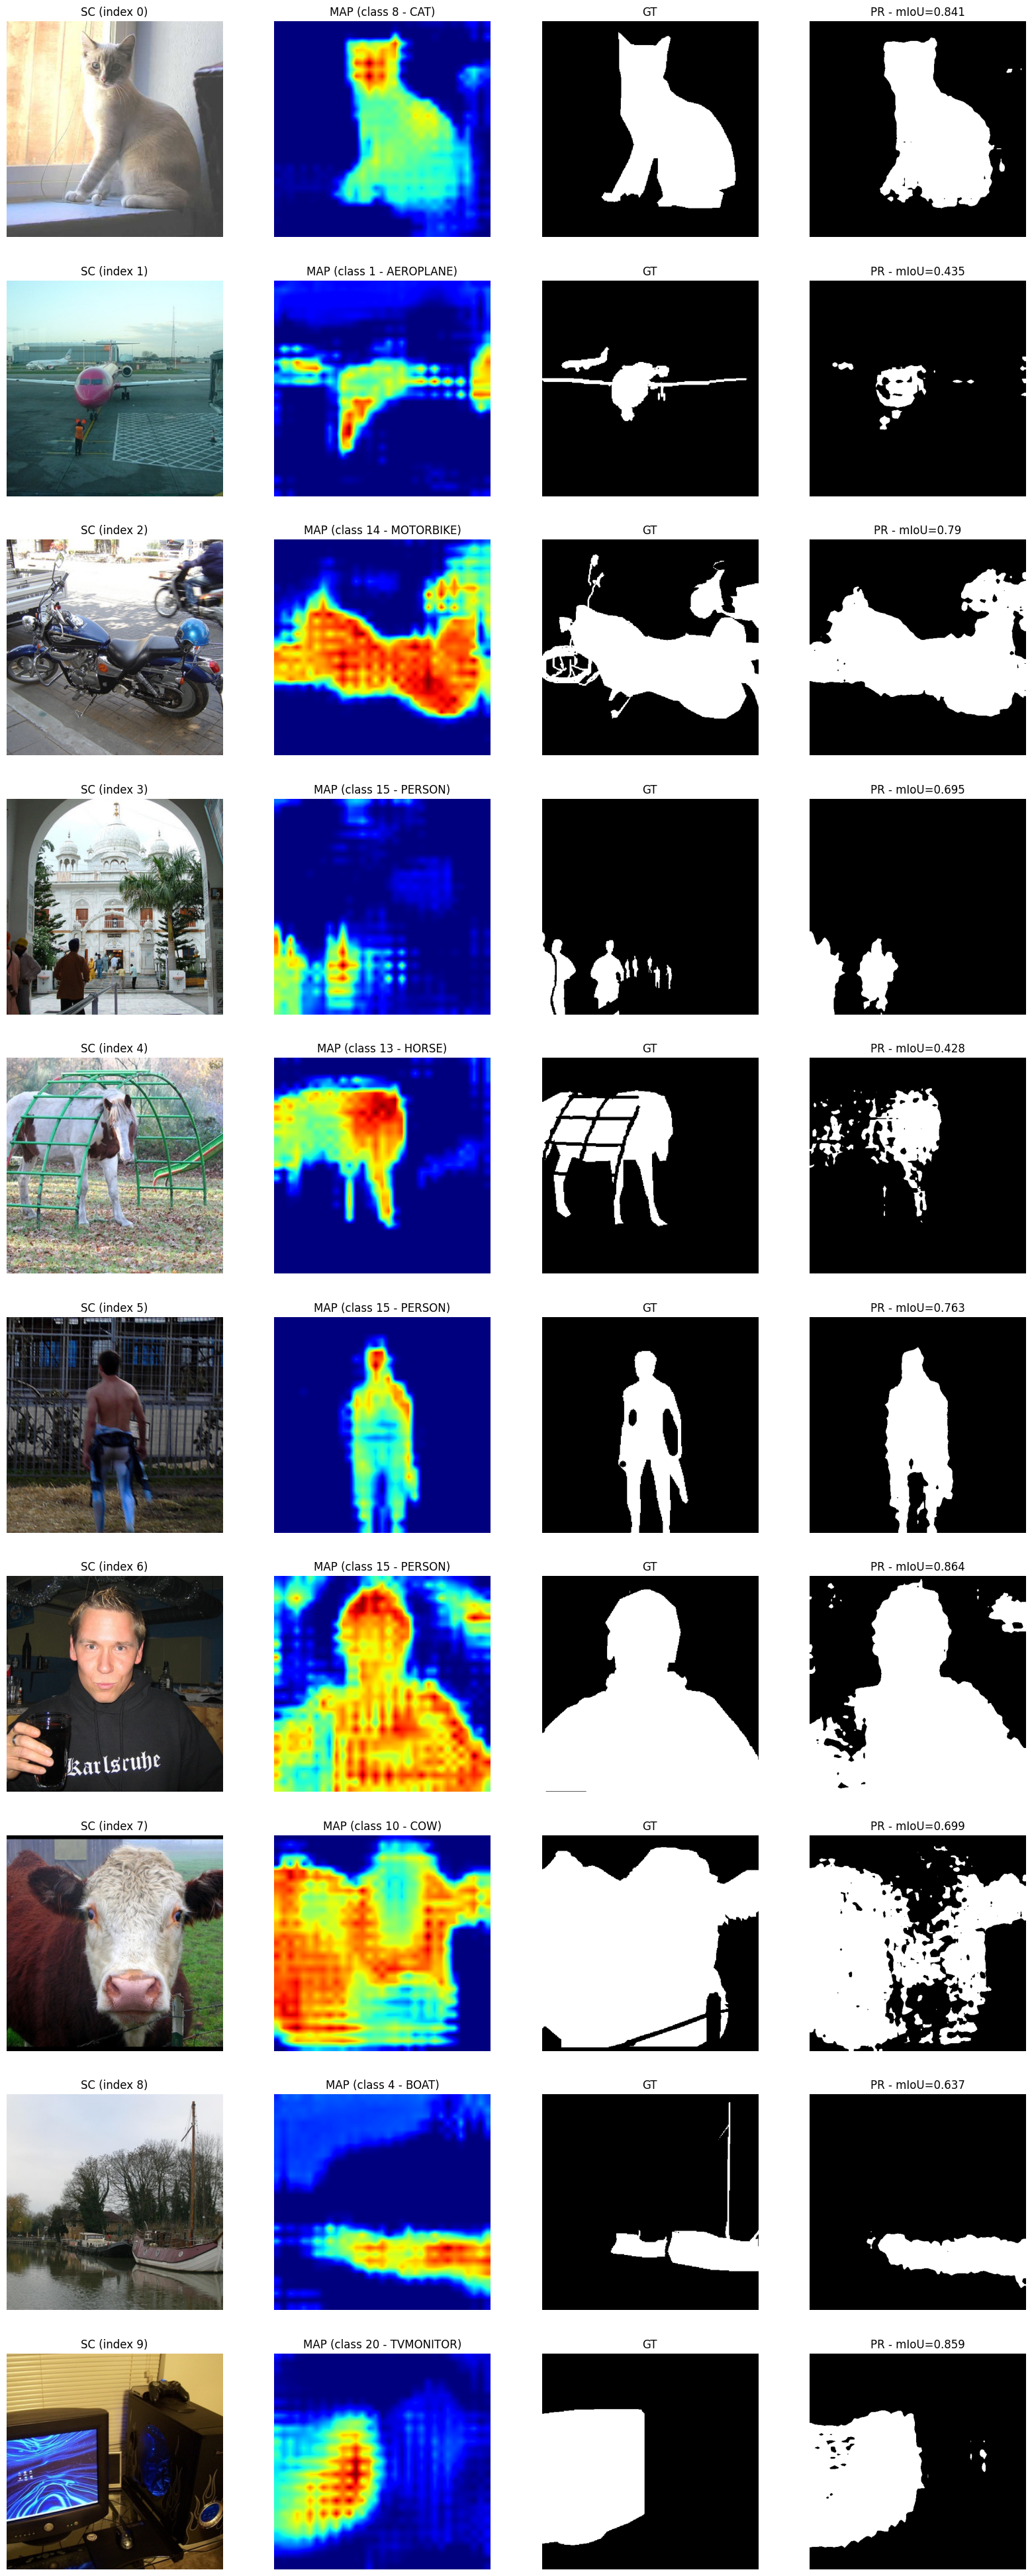

In [15]:
fig = viz_seg_saliency_maps(
    bck_imgs,
    cams,
    flat_target_classes,
    flat_target_class_names,
    gt_masks,
    pr_masks,
    alpha=0.5
)

In [16]:
segmodel.remove_handles()